# Create supersites_geom.geojson geojson file with the caucus supersite borders

## latest run of notebook: 
- 1/14/2024 7am
    
1. create supersites DataFrame from Judi's supersite precinct file
    - INPUT: data/2024_Supersite_list w Chairs & Cochairs.xlsx (update: 1/13/2024)
    - OUTPUT: data/pct_supersite.geojson 
2. create pctgeo (precinct GeoDataFrame)
    - INPUT: read precinct geometry from current pct_area_boulder.geojson file
    - add supersite name column using supersites dataframe
    - OUTPUT: save pctgeo to pct_supersites.geojson
3. create supersite border geometry and save geojson file
    - create ssgeo from pctgeo by using dissolve('supersite')
    - OUTPUT: 
    save ssgeo in supersite_region_geom.geojson

- NOTE: need to update precinct to Supersite geojson every time a Supersite/precinct list is modified 
    - e.g. move precincts 814 and 823 from Frasier to Manhatten

### Notebook History Summary
- full history see git commits
- Started: January 7, 2024
- Update: January 8, 2024 - large revision - add ssname column to supersites
- Update: January 9, 2024 - version 0.1.0 add ssgeom to supersitesgeo
- Update: January 11, 2024 - version 0.2.0 add pctlist column to supersites dataframe
- Update: January 12, 2024 - version 0.3.0 start supersite boundary geometry
- Update: January 13, 2024 - version 0.3.1 finish supersite boundary geometry

### Variables

- supersites    - DataFrame read from Judi's supersite file
- pctgeo        - GeoDataFrame read from pct_area_boulder.geojson
- sss_pcts_lists    - list of lists of all the precincts at a supersite
- ssgeo         - GeoDataFrame of supersites with region boundaries


##     ISSUES

#### FIXED Precinct format mismatch
- pct_area_boulder.geojson lists zero-filled precincts, e.g. 002, 003, 004
- Draft Supersites-judi-20240106.xlsx lists single-digit precincts, e.g. 2, 3, 4
    - notebook creates rows for both, 002 and 2, 003 and 3, 004 and 4
    - not critical failure but should be fixed. 
- WORKAROUND: drop extra rows 2, 3, 4
- FIXED: zfill precincts when reading in Judi's file


In [1]:
import pandas as pd
import geopandas as gpd
# import fiona
# import numpy as np

## 1. Create supersites - dataframe of supersites with list of precincts in a column  
- start with Judi's spreadsheet
- create pctlist from "Pct #'s" column
    - use pctstr_to_list(ss) function to create series of lists
    - add pctlist series as column on supersites

In [2]:
# FUNCTION: Convert column with string of precinct numbers to series with lists of precincts
#   e.g. for each row: '2, 101, 237, 304,,,,,' to [002, 101, 237, 304]

def pctstr_to_list(ss) :

    # transform each string in the list to a list of precinct numbers
    pctlist = ss["Pct #'s"].str.rstrip(',').str.split(',')

    # add leading zeros to single-digit precincts
    pctlist = [ [p.zfill(3) for p in pl] for pl in pctlist]
    
    return pctlist   


In [3]:
# Read current supersite list
supersite_xlsx = 'data/2024_Supersite_list w Chairs & Cochairs.xlsx' # 1/13/2024
supersites = pd.read_excel(supersite_xlsx, sheet_name='Recap SS & Precinct #s', skiprows=3)

# add pctlist column to supersites datafram
supersites = supersites.assign(pctlist = pctstr_to_list)
supersites = supersites[["Supersite", "# of Reg Dems", "Forecast of  Attendees",
       "# of Pct's", "Pct #'s", "pctlist"]]

supersites.info()
supersites.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Supersite               20 non-null     object 
 1   # of Reg Dems           20 non-null     int64  
 2   Forecast of  Attendees  20 non-null     float64
 3   # of Pct's              20 non-null     int64  
 4   Pct #'s                 20 non-null     object 
 5   pctlist                 20 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.1+ KB


,Supersite,# of Reg Dems,Forecast of Attendees,# of Pct's,Pct #'s,pctlist
0,Allenspark Fire Station,155,3.875,1,"914,,,,,,,,,,,,,,,,,,",[914]
1,Altona MS,7518,187.950,14,"605,606,607,608,609,610,611,614,615,616,624,62...","[605, 606, 607, 608, 609, 610, 611, 614, 615, ..."
2,Boulder HS,7241,181.025,10,"810,817,818,820,821,828,829,831,832,833,,,,,,,,,","[810, 817, 818, 820, 821, 828, 829, 831, 832, ..."
3,Burlington Elementary,3351,83.775,7,"600,601,602,603,604,612,613,,,,,,,,,,,,","[600, 601, 602, 603, 604, 612, 613]"
4,Casey MS,4696,117.400,7,"822,823,824,825,826,827,910,,,,,,,,,,,,","[822, 823, 824, 825, 826, 827, 910]"


In [4]:
# check pctlist 
# - list of precincts for each supersites
# - each precinct is 3-digits, e.g. 810 or 002
supersites['pctlist']

0                                                 [914]
1     [605, 606, 607, 608, 609, 610, 611, 614, 615, ...
2     [810, 817, 818, 820, 821, 828, 829, 831, 832, ...
3                   [600, 601, 602, 603, 604, 612, 613]
4                   [822, 823, 824, 825, 826, 827, 910]
5     [300, 301, 302, 303, 304, 305, 306, 307, 308, ...
6     [803, 804, 805, 806, 807, 811, 812, 813, 814, ...
7              [003, 100, 101, 102, 103, 104, 105, 106]
8         [400, 401, 402, 403, 404, 405, 406, 407, 408]
9                                                 [909]
10                                                [913]
11    [626, 627, 628, 629, 643, 644, 645, 646, 617, ...
12                            [700, 701, 702, 915, 916]
13    [004, 834, 835, 836, 837, 838, 839, 840, 841, ...
14    [200, 201, 202, 203, 204, 205, 206, 207, 208, ...
15                       [901, 902, 903, 904, 905, 907]
16    [503, 504, 505, 506, 507, 508, 509, 510, 800, ...
17    [830, 843, 844, 845, 846, 847, 850, 851, 8

## 2 create pctgeo (precinct GeoDataFrame)
- read precinct geometry from current pct_area_boulder.geojson file
- add supersite name column using supersites dataframe
- save as pct_supersite.geojson

In [5]:
# 2. Create pctgeo, GeoDataframe from file with individual precinct boundaries
# data/pct_area_boulder.geojson
pctgeo = gpd.read_file('data/pct_area_boulder.geojson', driver='GEOJSON')

# set pctgeo index to Pct
pctgeo = pctgeo.set_index('Pct', drop=False)

pctgeo.info()
pctgeo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 16.1+ KB


,Pct,Precinct,AreaShort,CD,SD,HD,geometry
Pct,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1..."
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9..."
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9..."
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9..."
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9..."


In [6]:
# FUNCTION: Add supersite name column to pctgeo

def add_ss_to_pctgeo(ssdf):

    for ss in ssdf.index:

        # get pctlist in first supersite
        pctlist = ssdf['pctlist'][ss]
        # print(pctlist, '\n')  # list of pcts in supersite

        # get supersite name
        ssname = ssdf.loc[ss,'Supersite'] 

        # loop through each pct in pctlist

        for p in pctlist:
            
            # print(p, ssname,'\n')

            # add supersite name to pctgeo
            pctgeo.loc[p, 'supersite'] = ssname
            # print(pctgeo.loc[p, :], '\n')  #  dataframe row
    return



In [7]:
# add supersite column to pctgeo and populate it
pctgeo['supersite'] = ''
add_ss_to_pctgeo(supersites)

pctgeo.info() # check all columns have 193 non-null values
pctgeo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  193 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 17.6+ KB


,Pct,Precinct,AreaShort,CD,SD,HD,geometry,supersite
Pct,,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1...",Trail Ridge MS
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9...",Eldorado K8
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9...",Manhattan MS
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9...",Eldorado K8
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9...",Eldorado K8


In [8]:
# ### Check precinct data in  geodataframe
# - Number of precincts = 193
# - Number of Areas = 27
# - Check precincts in each Area

pctgeo['Pct'].nunique() # 193
pctgeo.AreaShort.nunique() # 27
pctgeo.value_counts('AreaShort').sort_index()

AreaShort
BO-01     7
BO-02     5
BO-03     6
BO-04    10
BO-05     5
BO-07     6
BO-08     5
BO-09     5
BO-10     7
BO-11     6
ER-01     9
GN-01     7
LF-01     9
LF-02    11
LM-01     7
LM-02     7
LM-03     7
LM-04     9
LM-05     8
LM-06     8
LM-07    10
LV-01     7
LV-02     6
MT-01     6
MT-02     6
MT-03     6
SU-01     8
Name: count, dtype: int64

In [14]:
# check # of supersites - expect 20
pctgeo['supersite'].nunique()

# check precincts per supersite
pctgeo['supersite'].value_counts()

20

In [10]:
# save pctgeo with supersite column to file 
pctgeo.to_file('data/pct_supersite.geojson', driver='GeoJSON', index=False)

### 3 Create Supersite GeoDataFrame, ssgeo, and add geometry column 

- create ssgeo by dissolving pctgeo('supersite')
- save ssgeo to supersites_region_geom.geojson

supersite
Allenspark Fire Station     POLYGON ((-105.33835 40.25280, -105.33828 40.2...
Altona MS                   POLYGON ((-105.14621 40.12873, -105.14638 40.1...
Boulder HS                  POLYGON ((-105.26650 40.00008, -105.26776 40.0...
Burlington Elementary       POLYGON ((-105.12952 40.13073, -105.12974 40.1...
Casey MS                    POLYGON ((-105.25838 40.01917, -105.25838 40.0...
Centaurus HS                MULTIPOLYGON (((-105.05283 39.97775, -105.0624...
Centennial MS               POLYGON ((-105.27269 40.03465, -105.27268 40.0...
Eldorado K8                 POLYGON ((-105.14702 39.92762, -105.14702 39.9...
Erie MS                     POLYGON ((-105.05531 40.02197, -105.05532 40.0...
Gold Hill School            POLYGON ((-105.34886 40.03821, -105.34871 40.0...
Jamestown School            POLYGON ((-105.32867 40.10536, -105.32858 40.1...
Longs Peak MS               MULTIPOLYGON (((-105.13091 40.17667, -105.1309...
Lyons Middle Senior         POLYGON ((-105.13105 40.12

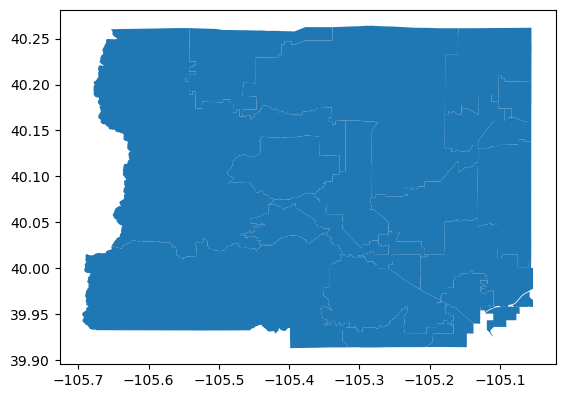

In [11]:
# Create ssgeo: Supersite GeoDataFrame with supersite boundaries
#   pctgeo.dissolve('supersite') 
#      group precincts by supersite 
#      combine group precinct geometry into supersite geometry

ssgeo = pctgeo.dissolve('supersite')
ssgeo = ssgeo['geometry']
ssgeo.to_file('data/supersites_region_geom.geojson', driver='GeoJSON')

ssgeo.plot()
ssgeo

### test areas.geojson

In [12]:
supersite_test = gpd.read_file('data/supersites_region_geom.geojson', driver='GeoJSON')
supersite_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   supersite  20 non-null     object  
 1   geometry   20 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 448.0+ bytes


<Axes: >

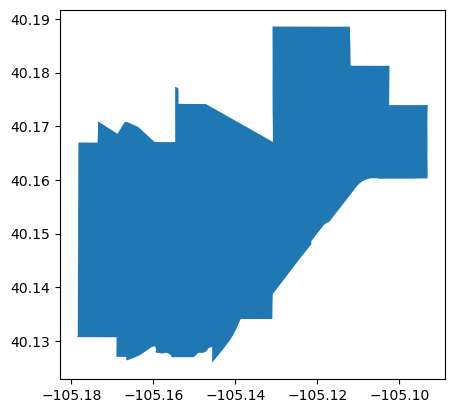

In [13]:
# supersite_test[supersite_test['supersite'] == 'Boulder HS'].plot()
supersite_test[supersite_test['supersite'] == 'Altona MS'].plot()